In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Layer
from keras.layers import Conv2D, Dense, Flatten, InputLayer, Normalization, MaxPool2D, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp
from keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import L1, L2
from keras.losses import BinaryCrossentropy
from keras.metrics import binary_accuracy
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import os
import cv2
import tensorflow_probability as tfp
import albumentations as A
import datetime
import wandb
from wandb.keras import WandbCallback
import io

2024-02-15 14:25:56.615986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 14:25:56.616074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 14:25:56.648308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 14:25:56.715741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 14:25:57.531605: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-02-15 14:25:59.979652: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 14:26:00.081341: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 14:26:00.081564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**WANDB**

In [3]:
#!wandb login 

In [4]:
#wandb.init(project="malaria_detection", entity='rutpatel4003')

In [5]:
#wandb.run

In [6]:
dataset, dataset_info=tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

2024-02-15 14:26:00.259434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 14:26:00.259698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-15 14:26:00.259859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
for data in dataset[0].take(1):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [8]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/home/rutpatel/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood

In [9]:
def split_data(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = dataset.skip(int((TRAIN_RATIO+VAL_RATIO)*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

In [10]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_dataset, val_dataset, test_dataset = split_data(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
#print(list(train_dataset.take(1).as_numpy_iterator()),
      #list(val_dataset.take(1).as_numpy_iterator()),
      #list(test_dataset.take(1).as_numpy_iterator()))
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Dataset Visualization

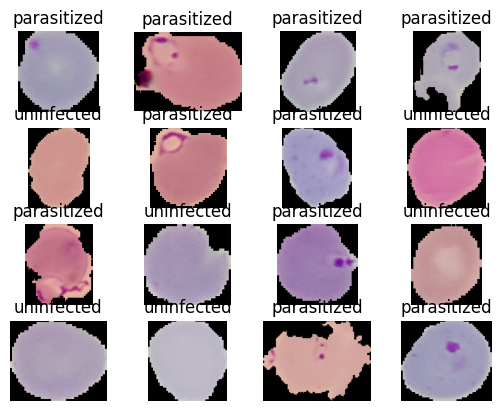

In [11]:
for i, (image,label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(image)
    plt.title(image) 
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

Data Preprocessing

**DATA AUGMENTATION**

In [12]:
#when we put @tf.function in all a function which has more methods in that function, tf.function will be applied to every method and not needed to call on every method in that function individually.
#even if we wanted to run the function many times, the graph mode would only provide the output once
#we can use tf.config.run_functions_eagerly(True) to run the function in eager mode all the time despite of having @tf.functions
#for example if we print in graph mode n times, it will only show once, we can use tf.print to print it as many times as we want
#to keep everything in a function based on tensorflow, we should avoid giving it any python variables and instead use tf variables
#if we turn away in graph mode, we should ensure that the function has only tensorflow operations
IM_SIZE = 224
def resizing(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

#or use the resize and rescaling layers

In [13]:
resize_rescale_layers = Sequential([
    Resizing(IM_SIZE, IM_SIZE),
    Rescaling(1.0/255),
])    

In [14]:
@tf.function
def augment(image, label):
    image, label = resizing(image, label)
    image = tf.image.rot90(image)
    image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
    image = tf.image.flip_left_right(image)

    return image, label

In [15]:
class RotNinety(Layer):
    def __init__(self):
        super().__init__()
    @tf.function
    def call(self, image):
        return tf.image.rot90(image)

In [16]:
augment_layers = Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal',),
])

@tf.function
def augment_layer(image, label):
    return augment_layers(resize_rescale_layers(image), training=True), label

**MIXUP DATA AUGMENTATION**


In [17]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).map(resizing)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [18]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    IM_SIZE = 224

    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = (lamda.sample(1)[0])

    image = lamda*image_1 + (1-lamda)*image_2
    label = lamda*tf.cast(label_1, dtype=tf.float32) + (1-lamda)*tf.cast(label_2, dtype=tf.float32)

    return image, label

**CUT-MIX AUGMENTATION**

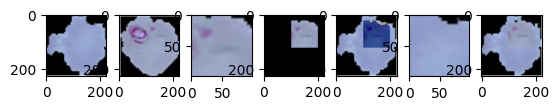

In [19]:
IM_SIZE = 224
plt.subplot(1, 7, 1)
image_1 = cv2.resize(cv2.imread('cell.png'), (IM_SIZE, IM_SIZE))
plt.imshow(image_1)

plt.subplot(1, 7, 2)
image_2 =cv2.resize(cv2.imread('cell2.png'), (IM_SIZE, IM_SIZE))
plt.imshow(image_2)

plt.subplot(1, 7, 3)
image_3 = tf.image.crop_to_bounding_box(image_2, 20, 100, 100, 98)
plt.imshow(image_3)

plt.subplot(1, 7, 4)
image_4 = (tf.image.pad_to_bounding_box(image_3, 20, 100, IM_SIZE, IM_SIZE ))
plt.imshow(image_4)

plt.subplot(1, 7, 5)
image_5 = plt.imshow(image_1 + image_4)

plt.subplot(1, 7, 6)
image_6 = tf.image.crop_to_bounding_box(image_1, 20, 100, 100, 98)
plt.imshow(image_6)

plt.subplot(1, 7, 7)
image_7 = (tf.image.pad_to_bounding_box(image_6, 20, 100, IM_SIZE, IM_SIZE ))
plt.imshow(image_1 - image_7 + image_4)

**Albumentations**

In [20]:
transforms = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.OneOf([A.HorizontalFlip(),
            A.VerticalFlip(),], p=0.3),
    A.RandomRotate90(),
    #A.RandomGridShuffle(grid=(3,3), always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2,
                             contrast_limit=0.2,
                             brightness_by_max=True,
                             always_apply=False, p=0.5),
    #A.CoarseDropout(num_holes = 8, max_h_size=8, max_w_size=8, fill_value=0, always_apply=False, p=0.5),
    #Sharpen(alpha=0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=0.5

])

In [21]:
def augment_albument(image):
    data = {"image": image}
    image = transforms(**data)
    image = image['image']
    image = tf.cast(image/255., tf.float32)
    return image

In [22]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=augment_albument, inp=[image], Tout = tf.float32)
    return aug_img, label

In [23]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True).map(process_data).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=32, reshuffle_each_iteration=True).map(resizing).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [24]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
 array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
      

In [25]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

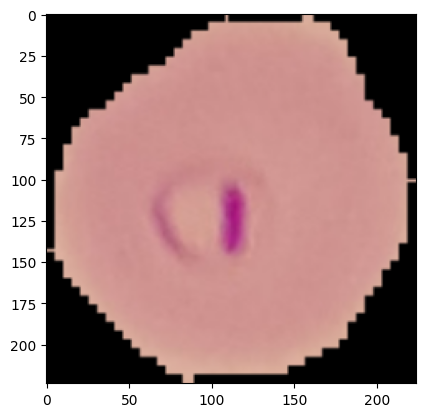

In [26]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

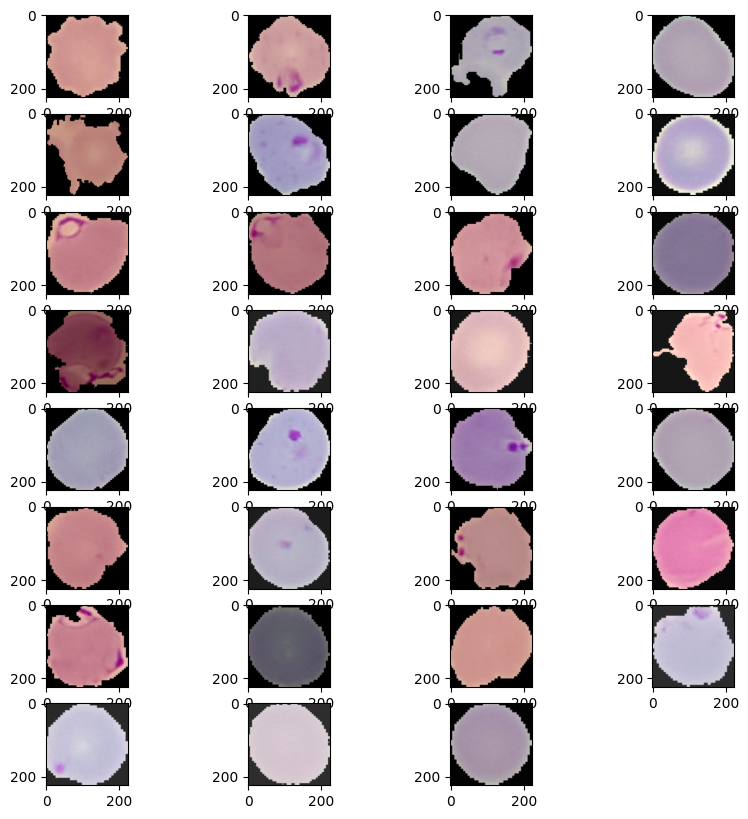

In [27]:
plt.figure(figsize=(10, 10))

for i in range(1, 32):
    plt.subplot(8, 4, i)
    plt.imshow(im[i])

In [28]:
def visualize(original, augmented):
    plt.subplot(1, 2, 1)
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.imshow(augmented)

In [29]:
original_image, label = train_dataset.as_numpy_iterator().next()
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [30]:
augmented_image = tf.image.flip_left_right(original_image[0])

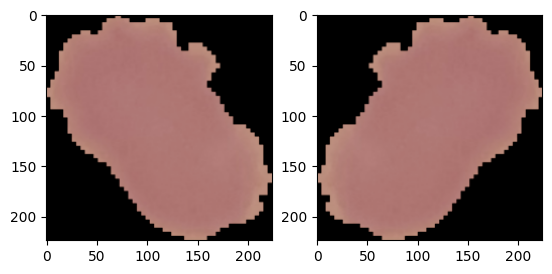

In [31]:
visualize(original_image[0], augmented_image)

In [32]:
for image,label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

**HYPER PARAMETER TUNING**

In [33]:
IM_SIZE = 224
#model = load_model('malaria_detection_final.h5')
'''def model_tune(hparams):
    model = Sequential([
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

        Conv2D(6, kernel_size=(3,3), strides=1, padding='valid', activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
        Dropout(rate = hparams[HP_DROPOUT]),

        Conv2D(16, kernel_size=(3,3), strides=1, padding='valid', activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),
        Dropout(0.3),

        Flatten(),

        Dense(hparams[HP_NUM_UNITS_1], activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        Dropout(rate = hparams[HP_DROPOUT]),

        Dense(hparams[HP_NUM_UNITS_2], activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
        BatchNormalization(),
        Dropout(rate = hparams[HP_DROPOUT]),
        
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hparams[HP_LEARNING_RATE]),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
    model.fit(val_dataset, epochs=1)
    _, accuracy = model.evaluate(val_dataset)
    return accuracy'''

"def model_tune(hparams):\n    model = Sequential([\n        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),\n\n        Conv2D(6, kernel_size=(3,3), strides=1, padding='valid', activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),\n        BatchNormalization(),\n        MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),\n        Dropout(rate = hparams[HP_DROPOUT]),\n\n        Conv2D(16, kernel_size=(3,3), strides=1, padding='valid', activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),\n        BatchNormalization(),\n        MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),\n        Dropout(0.3),\n\n        Flatten(),\n\n        Dense(hparams[HP_NUM_UNITS_1], activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),\n        BatchNormalization(),\n        Dropout(rate = hparams[HP_DROPOUT]),\n\n        Dense(hparams[HP_NUM_UNITS_2], activation='relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),

In [34]:
'''HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64, 128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16, 32, 64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.01, 0.001, 0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3, 1e-2]))'''

"HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16, 32, 64, 128]))\nHP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16, 32, 64, 128]))\nHP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.3]))\nHP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.01, 0.001, 0.1]))\nHP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3, 1e-2]))"

In [35]:
'''run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
    for num_units_2 in HP_NUM_UNITS_2.domain.values:
        for dropout_rate in HP_DROPOUT.domain.values:
                for learning_rate in HP_LEARNING_RATE.domain.values:
                    hparams = {
                        HP_NUM_UNITS_1: num_units_1,
                        HP_NUM_UNITS_2: num_units_2,
                        HP_DROPOUT: dropout_rate,
                        HP_REGULARIZATION_RATE: regularization_rate,
                        HP_LEARNING_RATE: learning_rate
                    }
                    file_writer = tf.summary.create_file_writer('logs/' + str(run_number))
                    with file_writer.as_default():
                        hp.hparams(hparams)
                        accuracy = model_tune(hparams)
                        tf.summary.scalar('accuracy', accuracy, step=run_number)
                    print('For the run {}: hparams num_units_1: {}, num_units_2: {}, dropout: {}, regularization_rate: {}, learning_rate: {}'.format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2], hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE], hparams[HP_LEARNING_RATE]))
                    run_number += 1'''

"run_number = 0\nfor num_units_1 in HP_NUM_UNITS_1.domain.values:\n    for num_units_2 in HP_NUM_UNITS_2.domain.values:\n        for dropout_rate in HP_DROPOUT.domain.values:\n                for learning_rate in HP_LEARNING_RATE.domain.values:\n                    hparams = {\n                        HP_NUM_UNITS_1: num_units_1,\n                        HP_NUM_UNITS_2: num_units_2,\n                        HP_DROPOUT: dropout_rate,\n                        HP_REGULARIZATION_RATE: regularization_rate,\n                        HP_LEARNING_RATE: learning_rate\n                    }\n                    file_writer = tf.summary.create_file_writer('logs/' + str(run_number))\n                    with file_writer.as_default():\n                        hp.hparams(hparams)\n                        accuracy = model_tune(hparams)\n                        tf.summary.scalar('accuracy', accuracy, step=run_number)\n                    print('For the run {}: hparams num_units_1: {}, num_units_2: {}, 

**HYPERPARAMETER TUNING FOR WANDB**

In [36]:
import wandb
!wandb login
wandb.run
sweep_config = {
    "name" : "Malaria-Prediction-Sweep",
    "method" : "random",
    "metric" :{
        "name" : "accuracy",
        "goal" : "maximize",
    },
    "parameters" : {
        "N_EPOCHS" : {
            "values" : [5, 10]
        },
        "NUM_UNIT_1" : {
            "values" : [16, 32, 64, 128]
        },
        "NUM_UNIT_2" : {
            "min" : 0.1,
            "max" : 0.4,
        },
        "DROPOUT" : {
            "values" : [0.1, 0.2, 0.3]
        },
        "REGULARIZATION_RATE" : {
            "distribution" : "uniform",
            "min" : 0.001,
            "max" : 0.1
        },

        "LEARNING_RATE" : {
            "distribution" : "uniform",
            "min" : 1e-4,
            "max" : 1e-2,
        },
        "N_STRIDES" : {
            "values" : [1],
        },
        "N_POOLSIZE" : {
            "values" : [2],
        },
        "IM_SIZE" :{
            "values" : [224],
        },
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb: Currently logged in as: rutpatel4003. Use `wandb login --relogin` to force relogin
Create sweep with ID: sgeps2q1
Sweep URL: https://wandb.ai/rutpatel4003/uncategorized/sweeps/sgeps2q1


**WANDB DATASET VERSIONING**

In [44]:
k=0
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])
for data, label in dataset[0]:
    with open('malaria_dataset_version/malaria_dataset_' + str(k) + '.npz', mode='wb') as file:
        np.savez(file, data)
    k+=1
    if(k%1000==0):
        print(k)
    
     

FileNotFoundError: [Errno 2] No such file or directory: 'malaria_dataset_version/malaria_dataset_0.npz'

In [45]:
def load_original_data():
    with wandb.init(project='malaria_detection', entity='rutpatel4003') as run:
        original_data = wandb.Artifact(name = 'new_dataset', type = 'raw_data', 
                                    description = 'The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.', 
        metadata = {"source" : "TFDS", 
                    "homepage" : 'https://lhncbc.nlm.nih.gov/publication/pub9932', "source_code": "tfds.datasets.malaria.Builder",
                    "version":"1.0.0",
                    "download_size" : "337.08 MiB",})
        dataset, dataset_info =  tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

        original_data.add_dir('malaria_dataset_version/')
        run.log_artifact(original_data)

In [46]:
load_original_data()

Problem at: /tmp/ipykernel_5781/2547843396.py 2 load_original_data


KeyboardInterrupt: 

In [40]:
with wandb.init(project='malaria_detection', entity='rutpatel4003') as run:
    artifact = run.use_artifact('rutpatel4003/malaria_detection/new_dataset:v0', type='raw_data')
    artifact_dir = artifact.download()

wandb: Currently logged in as: rutpatel4003. Use `wandb login --relogin` to force relogin


Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/apis/normalize.py", line 41, in wrapper
    return func(*args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/apis/public/api.py", line 961, in artifact
    artifact = wandb.Artifact._from_name(
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/sdk/artifacts/artifact.py", line 254, in _from_name
    raise ValueError(
ValueError: Unable to fetch artifact with name rutpatel4003/malaria_detection/new_dataset:v0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/tmp/ipykernel_5781/3343173093.py", line 2, in <module>
    artifact = run.use_artifact('rutpatel4003/malaria_detection/new_dataset:v0', type='raw_data')
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 371, in wrapp

CommError: Unable to fetch artifact with name rutpatel4003/malaria_detection/new_dataset:v0

In [37]:
IM_SIZE = 224
#model = load_model('malaria_detection_final.h5')
def model_tune(config):
    model = Sequential([
        InputLayer(input_shape=(config.IM_SIZE, config.IM_SIZE, 3)),

        Conv2D(filters=6, kernel_size=(3,3), strides=config.N_STRIDES, padding='valid', activation='relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=config.N_POOLSIZE, strides=config.N_STRIDES, padding='valid'),
        Dropout(rate = config.DROPOUT),

        Conv2D(filters=16, kernel_size=(3,3), strides=config.N_STRIDES, padding='valid', activation='relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=config.N_POOLSIZE, strides=config.N_STRIDES, padding='valid'),
        Dropout(rate = config.DROPOUT),

        Flatten(),

        Dense(config.NUM_UNIT_1, activation='relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
        BatchNormalization(),
        Dropout(rate = config.DROPOUT),

        Dense(config.NUM_UNIT_2, activation='relu', kernel_regularizer = L2(config.REGULARIZATION_RATE)),
        
        BatchNormalization(),
        Dropout(rate = config.DROPOUT),
        
        Dense(1, activation='sigmoid')
    ])

    return model

In [77]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 2,
    "BATCH_SIZE": 32,
    "DROPOUT_RATE": 0.3,
    "IM_SIZE": 224,
    "REGULARIZATION_RATE": 0.1,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 128,
    "N_DENSE_2": 32
}


In [39]:
import wandb

def train():
    with wandb.init(project='malaria_detection', entity='rutpatel4003', config=CONFIGURATION) as run:
        config = wandb.config
        model_test_wandb = model_tune(config)
        model_test_wandb.compile(optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE),
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy']),
        model_test_wandb.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])
count = 20
wandb.agent(sweep_id, function=train, count=count)


wandb: Agent Starting Run: 4djtpko8 with config:
wandb: 	DROPOUT: 0.3
wandb: 	IM_SIZE: 224
wandb: 	LEARNING_RATE: 0.005697393426401919
wandb: 	NUM_UNIT_1: 128
wandb: 	NUM_UNIT_2: 0.1652053097599364
wandb: 	N_EPOCHS: 5
wandb: 	N_POOLSIZE: 2
wandb: 	N_STRIDES: 1
wandb: 	REGULARIZATION_RATE: 0.016806564145378244
wandb: Currently logged in as: rutpatel4003. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5


2024-02-15 03:51:13.784518: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-15 03:51:14.779885: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 03:51:16.363779: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f12097746a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 03:51:16.363805: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-15 03:51:16.367408: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707949276.411497   14583 device_compiler.h:186] Compiled clust

 6/87 [=>............................] - ETA: 5s - loss: 9.8567 - accuracy: 0.5312 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0202s vs `on_train_batch_end` time: 0.0362s). Check your callbacks.


87/87 [==============================] - 12s 67ms/step - loss: 1.8414 - accuracy: 0.5024
Epoch 2/5
87/87 [==============================] - 6s 64ms/step - loss: 0.6934 - accuracy: 0.5056
Epoch 3/5
87/87 [==============================] - 6s 64ms/step - loss: 0.6932 - accuracy: 0.5064
Epoch 4/5
87/87 [==============================] - 7s 64ms/step - loss: 0.6933 - accuracy: 0.5031
Epoch 5/5
87/87 [==============================] - 6s 64ms/step - loss: 0.6932 - accuracy: 0.4973


accuracy,▅▇█▅▁
epoch,▁▃▅▆█
loss,█▁▁▁▁
accuracy,0.49728
epoch,4
loss,0.69321


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aw1uor1b with config:
wandb: 	DROPOUT: 0.2
wandb: 	IM_SIZE: 224
wandb: 	LEARNING_RATE: 0.0007593637226849542
wandb: 	NUM_UNIT_1: 128
wandb: 	NUM_UNIT_2: 0.3929817996902872
wandb: 	N_EPOCHS: 10
wandb: 	N_POOLSIZE: 2
wandb: 	N_STRIDES: 1
wandb: 	REGULARIZATION_RATE: 0.03404855350247577
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10
 6/87 [=>............................] - ETA: 5s - loss: 3.8311 - accuracy: 0.5156WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0215s vs `on_train_batch_end` time: 0.0379s). Check your callbacks.


87/87 [==============================] - 8s 64ms/step - loss: 1.3104 - accuracy: 0.5064
Epoch 2/10
87/87 [==============================] - 6s 64ms/step - loss: 0.7795 - accuracy: 0.5056
Epoch 3/10
87/87 [==============================] - 6s 64ms/step - loss: 0.7204 - accuracy: 0.5045
Epoch 4/10
87/87 [==============================] - 6s 64ms/step - loss: 0.7016 - accuracy: 0.5064
Epoch 5/10
87/87 [==============================] - 6s 64ms/step - loss: 0.6958 - accuracy: 0.5053
Epoch 6/10
87/87 [==============================] - 6s 64ms/step - loss: 0.6939 - accuracy: 0.5064
Epoch 7/10
87/87 [==============================] - 6s 64ms/step - loss: 0.6934 - accuracy: 0.5038
Epoch 8/10
87/87 [==============================] - 6s 64ms/step - loss: 0.6932 - accuracy: 0.5024
Epoch 9/10
87/87 [==============================] - 6s 64ms/step - loss: 0.6932 - accuracy: 0.5042
Epoch 10/10
87/87 [==============================] - 7s 64ms/step - loss: 0.6931 - accuracy: 0.5060


accuracy,█▇▅█▆█▄▁▄▇
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▂▁▁▁▁▁▁▁▁
accuracy,0.50599
epoch,9
loss,0.69313


wandb: Agent Starting Run: p3s0znvg with config:
wandb: 	DROPOUT: 0.1
wandb: 	IM_SIZE: 224
wandb: 	LEARNING_RATE: 0.0017593739772369936
wandb: 	NUM_UNIT_1: 128
wandb: 	NUM_UNIT_2: 0.3161012966104759
wandb: 	N_EPOCHS: 10
wandb: 	N_POOLSIZE: 2
wandb: 	N_STRIDES: 1
wandb: 	REGULARIZATION_RATE: 0.05725725694118121
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/10


2024-02-15 03:53:28.639385: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-15 03:53:38.750337: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op gradient_tape/dense/kernel/Regularizer/mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:53:38.750375: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:53:38.750390: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 190, Chunks in use: 190. 47.5KiB allocated for chunks. 47.5KiB 

Run p3s0znvg errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 10, in train
    model_test_wandb.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/dense/kernel/Regularizer/mul defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973

2024-02-15 03:54:01.216604: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 185.64MiB (rounded to 194658304)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:54:01.216677: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:54:01.216715: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 183, Chunks in use: 183. 45.8KiB allocated for chunks. 45.8KiB in use in bin. 3.8KiB client-requested in use in bin.
2024-02-15 03:54:01.216731: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 41, Chunks in use: 41. 22.8KiB allocated for chunks. 22.8KiB in use in bin. 21.6KiB client-requested in use in bin.
2024-02-15 03:54:01.2

Run 0iuhxxy7 errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:54:30.360959: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:54:30.361030: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:54:30.361065: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 195, Chunks in use: 195. 48.8KiB allocated for chunks. 48.8KiB in use in bin. 4.3KiB client-requested in use in bin.
2024-02-15 03:54:30.361092: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 42, Chunks in use: 42. 23.5KiB allocated for chunks. 23.5KiB in use in bin. 22.2KiB client-requested in use in bin.
20

Run 8wt7jbvx errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

Epoch 1/10


2024-02-15 03:54:44.467872: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-15 03:54:55.410419: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 93.67MiB (rounded to 98224128)requested by op sequential/conv2d_1/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:54:55.410454: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:54:55.410462: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 264, Chunks in use: 264. 66.0KiB allocated for chunks. 66.0KiB in use in bin. 6.2Ki

Run sjljrfaj errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 10, in train
    model_test_wandb.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node sequential/conv2d_1/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

 

2024-02-15 03:55:15.141105: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:55:15.141169: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:55:15.141185: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 265, Chunks in use: 265. 66.2KiB allocated for chunks. 66.2KiB in use in bin. 6.5KiB client-requested in use in bin.
2024-02-15 03:55:15.141196: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 46, Chunks in use: 46. 26.5KiB allocated for chunks. 26.5KiB in use in bin. 24.7KiB client-requested in use in bin.
20

Run 44gc61ma errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

Epoch 1/5


2024-02-15 03:55:39.421817: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 36.10MiB (rounded to 37850112)requested by op sequential/conv2d/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:55:39.421884: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:55:39.421908: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 331, Chunks in use: 330. 82.8KiB allocated for chunks. 82.5KiB in use in bin. 8.4KiB client-requested in use in bin.
2024-02-15 03:55:39.421924: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 50, Chunks in use: 50. 29.5KiB allocated for chunks. 29.5KiB in use in bin. 27.3KiB client-requested in use in bin.
2024-0

Run x7tc83li errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 10, in train
    model_test_wandb.fit(val_dataset, epochs=config.N_EPOCHS, callbacks=[WandbCallback()])
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Graph execution error:

Detected at node sequential/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  F

2024-02-15 03:56:08.866708: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 92.82MiB (rounded to 97329152)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:56:08.866788: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:56:08.866818: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 336, Chunks in use: 336. 84.0KiB allocated for chunks. 84.0KiB in use in bin. 8.7KiB client-requested in use in bin.
2024-02-15 03:56:08.866829: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 49, Chunks in use: 49. 28.8KiB allocated for chunks. 28.8KiB in use in bin. 26.6KiB client-requested in use in bin.
2024-02-15 03:56:08.86683

Run ry1vztnb errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:56:30.003071: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 46.41MiB (rounded to 48664576)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:56:30.003129: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:56:30.003146: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 348, Chunks in use: 348. 87.0KiB allocated for chunks. 87.0KiB in use in bin. 9.1KiB client-requested in use in bin.
2024-02-15 03:56:30.003156: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 50, Chunks in use: 50. 29.5KiB allocated for chunks. 29.5KiB in use in bin. 27.3KiB client-requested in use in bin.
2024

Run s6k08b6t errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:56:51.867594: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 92.82MiB (rounded to 97329152)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:56:51.867650: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:56:51.867666: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 9.6KiB client-requested in use in bin.
2024-02-15 03:56:51.867678: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 51, Chunks in use: 51. 30.2KiB allocated for chunks. 30.2KiB in use in bin. 27.9KiB client-requested in use in bin.
2024

Run 5qozjnmh errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:57:13.937507: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:57:13.937585: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:57:13.937611: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 372, Chunks in use: 372. 93.0KiB allocated for chunks. 93.0KiB in use in bin. 10.0KiB client-requested in use in bin.
2024-02-15 03:57:13.937646: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 51, Chunks in use: 51. 30.2KiB allocated for chunks. 30.2KiB in use in bin. 27.9KiB client-requested in use in bin.
2

Run frmfymdo errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:57:35.728416: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 46.41MiB (rounded to 48664576)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:57:35.728461: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:57:35.728469: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 384, Chunks in use: 384. 96.0KiB allocated for chunks. 96.0KiB in use in bin. 10.5KiB client-requested in use in bin.
2024-02-15 03:57:35.728474: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 52, Chunks in use: 52. 31.0KiB allocated for chunks. 31.0KiB in use in bin. 28.5KiB client-requested in use in bin.
202

Run deeitn69 errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:58:04.802596: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 92.82MiB (rounded to 97329152)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:58:04.802664: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:58:04.802680: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 364, Chunks in use: 364. 91.0KiB allocated for chunks. 91.0KiB in use in bin. 10.8KiB client-requested in use in bin.
2024-02-15 03:58:04.802690: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 54, Chunks in use: 53. 32.2KiB allocated for chunks. 31.8KiB in use in bin. 29.2KiB client-requested in use in bin.
202

Run 6dkch2nc errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:58:26.523342: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 371.28MiB (rounded to 389316608)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:58:26.523404: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:58:26.523426: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 376, Chunks in use: 376. 94.0KiB allocated for chunks. 94.0KiB in use in bin. 11.3KiB client-requested in use in bin.
2024-02-15 03:58:26.523442: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 54, Chunks in use: 54. 32.5KiB allocated for chunks. 32.5KiB in use in bin. 29.8KiB client-requested in use in bin.
2

Run w6wmeyac errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:58:49.705929: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 46.41MiB (rounded to 48664576)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:58:49.705988: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:58:49.706003: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 388, Chunks in use: 388. 97.0KiB allocated for chunks. 97.0KiB in use in bin. 11.7KiB client-requested in use in bin.
2024-02-15 03:58:49.706014: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 55, Chunks in use: 55. 33.2KiB allocated for chunks. 33.2KiB in use in bin. 30.4KiB client-requested in use in bin.
202

Run 82sp9c2h errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:59:11.725509: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 185.64MiB (rounded to 194658304)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:59:11.725566: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:59:11.725583: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 400, Chunks in use: 400. 100.0KiB allocated for chunks. 100.0KiB in use in bin. 12.2KiB client-requested in use in bin.
2024-02-15 03:59:11.725594: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 55, Chunks in use: 55. 33.2KiB allocated for chunks. 33.2KiB in use in bin. 30.4KiB client-requested in use in bin.

Run oi90baj1 errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:59:33.362618: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 185.64MiB (rounded to 194658304)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:59:33.362727: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:59:33.362761: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 412, Chunks in use: 412. 103.0KiB allocated for chunks. 103.0KiB in use in bin. 12.6KiB client-requested in use in bin.
2024-02-15 03:59:33.362786: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 56, Chunks in use: 56. 34.0KiB allocated for chunks. 34.0KiB in use in bin. 31.1KiB client-requested in use in bin.

Run w1qg5kta errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 03:59:54.882127: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 92.82MiB (rounded to 97329152)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 03:59:54.882195: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 03:59:54.882219: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 424, Chunks in use: 424. 106.0KiB allocated for chunks. 106.0KiB in use in bin. 13.1KiB client-requested in use in bin.
2024-02-15 03:59:54.882230: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 56, Chunks in use: 56. 34.0KiB allocated for chunks. 34.0KiB in use in bin. 31.1KiB client-requested in use in bin.
2

Run n5x1rf3r errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

2024-02-15 04:00:24.018839: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 92.82MiB (rounded to 97329152)requested by op StatelessRandomUniformV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-02-15 04:00:24.018893: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-02-15 04:00:24.018910: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 436, Chunks in use: 436. 109.0KiB allocated for chunks. 109.0KiB in use in bin. 13.5KiB client-requested in use in bin.
2024-02-15 04:00:24.018921: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 57, Chunks in use: 57. 34.8KiB allocated for chunks. 34.8KiB in use in bin. 31.7KiB client-requested in use in bin.
2

Run zksp6208 errored:
Traceback (most recent call last):
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_14486/2560282547.py", line 6, in train
    model_test_wandb = model_tune(config)
  File "/tmp/ipykernel_14486/2338709272.py", line 4, in model_tune
    model = Sequential([
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/rutpatel/Documents/deeplearning/dl/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExh

**MODEL DEFINING USING WANDB**

In [78]:

'''IM_SIZE =  CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']
N_DENSE_1 = CONFIGURATION['N_DENSE_1']
N_DENSE_2 = CONFIGURATION['N_DENSE_2']

model_wandb = Sequential([
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

        Conv2D(filters=N_FILTERS, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2, padding='valid'),
        Dropout(DROPOUT_RATE),

        Conv2D(filters=N_FILTERS*2+4, kernel_size=KERNEL_SIZE, strides=N_STRIDES, padding='valid', activation='relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
        BatchNormalization(),
        MaxPool2D(pool_size=POOL_SIZE, strides=N_STRIDES*2, padding='valid'),
        Dropout(DROPOUT_RATE),

        Flatten(),

        Dense(N_DENSE_1, activation='relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),

        Dense(N_DENSE_2, activation='relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        
        Dense(1, activation='sigmoid')
    ])
model_wandb.summary()'''

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)     

**Callback**

In [79]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {}: The model has has a loss of {}".format(epoch+1, logs['loss']))
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {}: The model has as loss of {}".format(batch+1, logs))

In [80]:
csv_callback = CSVLogger(
    'logs_malaria.csv', separator=',', append=False
)

In [81]:
es_callback = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline = None, restore_best_weights=False
)

**TENSORBOARD MANUAL LOGGING**

In [82]:
METRIC_DIR = './logs/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

**LEARNING RATE SCHEDULER**

In [83]:
def scheduler(epoch, lr):
    if epoch <= 1:
        learning_rate = lr
    else:
        learning_rate = lr * tf.math.exp(-0.1)
    with train_writer.as_default():
        tf.summary.scalar('Learning Rate', data=learning_rate, step=epoch)
    return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

**MODEL CHECKPOINT**

In [84]:
checkpoint_callback = ModelCheckpoint(
    'malaria_checkpoint/', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch'
)

**REDUCE LEARNING RATE ON PLATEAU**

In [85]:
plateau_callback = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=0.2, verbose=1
)

**TENSORBOARD CALLBACK**

In [86]:
CURRENT_TIME = datetime.datetime.now().strftime("%d%m%y-%h%m%s")
METRIC_DIR = './logs/' + CURRENT_TIME + '/metrics/'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

In [87]:
LOG_DIR = './logs/' + datetime.datetime.now().strftime('%D%M%Y - %H%M%S')
print(LOG_DIR)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="LOG_DIR", histogram_freq=1, profile_batch='100, 132')

./logs/02/15/24312024 - 113121


2024-02-15 11:31:21.269735: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-02-15 11:31:21.269776: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-02-15 11:31:21.269834: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-02-15 11:31:21.302888: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:163] cuptiEnableCallback: error 1: CUPTI_ERROR_INVALID_PARAMETER
2024-02-15 11:31:21.302927: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-02-15 11:31:21.302933: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:449] CuptiErrorManager is disabling profiling automatically.
2024-02-15 11:31:21.302953: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
202

**CUSTOM LOSS CLASS**

In [88]:
class CustomBCE(keras.losses.Loss):
    def __init__(self, FACTOR):
        super(CustomBCE, self).__init__()
        self.FACTOR = FACTOR

    def call(self, y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred) * self.FACTOR

**CUSTOM LOSS(with parameters)**

In [89]:
FACTOR = 1
def custom_bce_w_parameters():
    def loss(y_true, y_pred):
        bce = BinaryCrossentropy()
        return bce(y_true, y_pred)
    return loss

**CUSTOM METRICS** (without parameters)

In [90]:
def custom_accuracy(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

**CUSTOM METRICS** (with parameters)

In [91]:
FACTOR = 1
def custom_accuracy(FACTOR):
    def metric(y_true, y_pred):
        return binary_accuracy(y_true, y_pred) * FACTOR
    return metric

**CUSTOM METRICS CLASS**

In [92]:
class CustomAccuracy(keras.metrics.Metric):
    def __init__(self, name='Custom_Accuracy', FACTOR=1):
        super(CustomAccuracy, self).__init__()
        self.FACTOR = FACTOR
        self.accuracy = self.add_weight(name=name, initializer=  'zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        output = binary_accuracy(tf.cast(y_true, dtype=tf.float32), y_pred) * self.FACTOR
        self.accuracy.assign(tf.math.count_nonzero(output, dtype=tf.float32)/tf.cast(len(output), dtype=tf.float32))
        
    def result(self):
        return self.accuracy
        
    def reset_states(self):
        self.accuracy.assign(0.)

**Log Images Callback**

In [93]:
class LogImagesCallbackWandB(Callback):
    def on_epoch_end(self, epoch, logs):
        labels= []
        inp = []

        for x, y, in test_dataset.as_numpy_iterator():
            inp.append(x)
            labels.append(y)
        labels = np.array([i for i in labels])
        predicted = model_wandb.predict(np.array(inp)[:, :, :, ...])


        pred = []
        for i in range(len(predicted)):
            if predicted[i][0] < 0.5:
                pred.append([1, 0])
            else:
                pred.append([0, 1])
        pred = np.array(pred)
        wandb.log({"Confusion Matrix" : wandb.plot.confusion_matrix(probs=pred, y_true=labels, class_names=['Parasitized', 'Uninfected'])})

In [94]:
metrics = [TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
model_wandb.compile(optimizer=keras.optimizers.Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
              loss = custom_bce_w_parameters())
LABELS = ['Parasitized', 'Uninfected']

In [99]:
history = model_wandb.fit(train_dataset, epochs=CONFIGURATION['N_EPOCHS'], callbacks=[LogImagesCallbackWandB()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/2


2024-02-15 11:32:44.329898: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-15 11:32:44.530565: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 11:32:46.119691: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f958bff1200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 11:32:46.119731: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-15 11:32:46.128194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707976966.208369    5695 device_compiler.h:186] Compiled clu

689/689 [==============================] - ETA: 0s - loss: 4.7429

IndexError: list index out of range

**TENSORBOARD LOGGING**

In [56]:
wandb.finish()

In [48]:
%load_ext tensorboard

In [53]:
%tensorboard --logdir=LOG_DIR

Reusing TensorBoard on port 6007 (pid 102561), started 0:00:14 ago. (Use '!kill 102561' to kill it.)

**CREATION OF CUSTOM .FIT METHOD**

In [95]:
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

In [96]:
def training_block(x_batch, y_batch):
    with tf.GradientTape() as recorder:
        y_pred = model(x_batch, training=True)
        loss = custom_bce(y_batch, y_pred)
        
    partial_derivates = recorder.gradient(loss, model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivates, model.trainable_weights))
    METRIC.update_state(y_batch, y_pred)

    return loss

In [97]:
def validation_block(x_batch_val, y_batch_val):

    y_pred_val = model(x_batch_val, training=False)
    val_loss = custom_bce(y_batch_val, y_pred_val)
    METRIC.update_state(y_batch_val, y_pred_val)
    
    return val_loss

In [98]:
def custom_training_loop(model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS):   
    for epoch in range(EPOCHS):
        print("Training starts for epoch {}".format(epoch+1))
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            loss = training_block(x_batch, y_batch)
        
        print("Training Loss: ", loss)
        print("The accuracy is: ", METRIC.result())
        METRIC.reset_states()

        for (x_batch_val, y_batch_val) in val_dataset:
            val_loss = validation_block(x_batch_val, y_batch_val)
        print("The validation accuracy is: ", METRIC_VAL.result())
        METRIC_VAL.reset_states()

        print("Validation Loss: ", val_loss)

In [99]:
custom_training_loop(model, custom_bce, METRIC, METRIC_VAL, OPTIMIZER, train_dataset, val_dataset, EPOCHS)

Training starts for epoch 1
Training Loss:  tf.Tensor(0.105328545, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.9413953, shape=(), dtype=float32)
The validation accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Validation Loss:  tf.Tensor(0.22232465, shape=(), dtype=float32)
Training starts for epoch 2
Training Loss:  tf.Tensor(0.17793486, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.9227854, shape=(), dtype=float32)
The validation accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Validation Loss:  tf.Tensor(0.77420217, shape=(), dtype=float32)
Training starts for epoch 3
Training Loss:  tf.Tensor(0.23904012, shape=(), dtype=float32)
The accuracy is:  tf.Tensor(0.9309302, shape=(), dtype=float32)
The validation accuracy is:  tf.Tensor(0.0, shape=(), dtype=float32)
Validation Loss:  tf.Tensor(1.1179308, shape=(), dtype=float32)


In [ ]:
#model.save('malaria_detection_final.h5')

In [28]:
#model = load_model('malaria_detection_final.h5')
#model.evaluate(test_dataset)

In [37]:
image = cv2.imread('cell2.png')
print(image.shape)
image = tf.expand_dims(image, axis = 0)
print(image.shape)
test_check = model.predict(tf.image.resize(image, [224, 224]))
print(test_check)

(115, 115, 3)
(1, 115, 115, 3)
1/1 [==============================] - 0s 16ms/step
[[1.]]


In [82]:
!rm -rf ./logs/
test_dataset.as_numpy_iterator().next()

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 0)

In [27]:
def parasite_or_not(x):
    if(x<0.5):
        return (str('P'))
    else:
        return (str('U'))

In [28]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

2024-02-04 15:46:27.423869: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 2s 2s/step


'U'

1/1 [==============================] - 0s 12ms/step


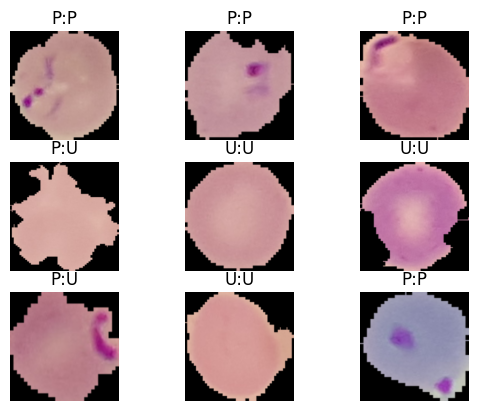

In [29]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

    plt.axis('off')

In [30]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Functional API**

In [17]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = 'Input Image')

x = Conv2D(6, kernel_size=(3,3), strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), strides=2, padding='valid')(x)

x = Conv2D(16, kernel_size=(3,3), strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=(2,2), strides=2, padding='valid')(x)

feature_extractor_model = Model(func_input, output, name = 'Feature_Extractor_Model')
feature_extractor_model.summary()


Model: "Feature_Extractor_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_8 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_9 (Bat  (None, 109, 10

In [21]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name = 'Input Image')

x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
    
func_output = Dense(1, activation='sigmoid')(x)

model_func = Model(func_input, func_output, name = 'Lenet_Model')
model_func.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor_Model (F  (None, 54, 54, 16)        1136      
 unctional)                                                      
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_4 (Dense)             (None, 10)                

**SEQUENTIAL API MODEL USING FUNCTIONAL API**

In [87]:
feature_extractor_sequential = Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(6, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(16, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid')])

In [88]:
'''x = feature_extractor_sequential(func_input)

x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
    
func_output = Dense(1, activation='sigmoid')(x)

model_func = Model(func_input, func_output, name = 'Lenet Model')
model_func.summary()'''

Model: "Lenet Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_6 (Flatten)         (None, 46656)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_26 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                       

**MODEL SUBCLASSING**

In [94]:
class FeatureExtractor(Layer):
    def __init__(self, filters, kernel_size, strides, padding, activation, pool_size, **kwargs):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size = pool_size, strides=2*strides)

        self.conv_2 = Conv2D(filters = filters*2, kernel_size = kernel_size, strides = strides, padding = padding, activation = activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size = pool_size, strides=2*strides)


    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)

        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x
feature_sub_classes = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

In [95]:
x = feature_sub_classes(func_input)
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

x = Dense(10, activation='relu')(x)
x = BatchNormalization()(x)
    
func_output = Dense(1, activation='sigmoid')(x)

model_sub_class = Model(func_input, func_output, name = 'Feature_Extractor_Sub_Class_Model')
model_sub_class.summary()

Model: "Feature_Extractor_Sub_Class_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_1 (Featu  (None, 54, 54, 16)        1488      
 reExtractor)                                                    
                                                                 
 flatten_8 (Flatten)         (None, 46656)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_34 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (Non

In [101]:
class SubclassesModel(Model):
    def __init__(self, **kwargs):
        super(SubclassesModel, self).__init__()
        self.feature_extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)
        self.flatten = Flatten()
        self.dense_1 = Dense(100, activation='relu')
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation='relu')
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation='relu')
    

    def call(self, x, training):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.dense_2(x)
        x = self.batch_2(x)
        x = self.dense_3(x)

        return x

model_sub_classed = SubclassesModel()
model_sub_classed(tf.zeros([1, 224, 224, 3]))
model_sub_classed.summary()


Model: "subclasses_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_6 (Featu  multiple                  1488      
 reExtractor)                                                    
                                                                 
 flatten_13 (Flatten)        multiple                  0         
                                                                 
 dense_39 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_54 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_40 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_55 (Ba  multiple           

**CUSTOM LAYER**

In [12]:
class CustomDenseLayer(Layer):
    def __init__(self, output_units, activation):
        super(CustomDenseLayer, self).__init__()
        self.output_units = output_units
        self.activation=activation

    def build(self, input_features_shape):
        self.w=self.add_weight(shape=(input_features_shape[-1], self.output_units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.output_units,), initializer = "random_normal", trainable=True)
    
    def call(self, input_features):
        preoutput = tf.matmul(input_features, self.w) + self.b
        if self.activation=='relu':
            return tf.nn.relu(preoutput)
        elif self.activation=='sigmoid':
            return tf.math.sigmoid(preoutput)
        else:
            return tf.matmul(preoutput)

In [14]:
custom_model = Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(6, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(16, kernel_size=(3,3), strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2, padding='valid'),

    Flatten(),

    CustomDenseLayer(100, activation='relu'),
    BatchNormalization(),

    CustomDenseLayer(10, activation='relu'),
    BatchNormalization(),
    
    CustomDenseLayer(1, activation='sigmoid')
])
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 222, 222, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [31]:
labels = []
inp = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    inp.append(x)


In [32]:
print(np.array(inp).shape)
print(np.array(inp)[:, 0, ...].shape)

(2756, 1, 224, 224, 3)
(2756, 224, 224, 3)


In [33]:
predicted = model.predict(np.array(inp)[:, 0, ...])
print(predicted[:, 0])

2024-02-04 15:46:56.105685: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1659420672 exceeds 10% of free system memory.
2024-02-04 15:46:57.505135: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1659420672 exceeds 10% of free system memory.


87/87 [==============================] - 1s 8ms/step
[9.6149033e-01 3.6430858e-08 8.4343873e-04 ... 6.3531423e-11 9.9771464e-01
 9.9513876e-01]


In [51]:
threshold = 0.5286
cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[1305   87]
 [ 162 1202]]


Text(70.72222222222221, 0.5, 'Actual')

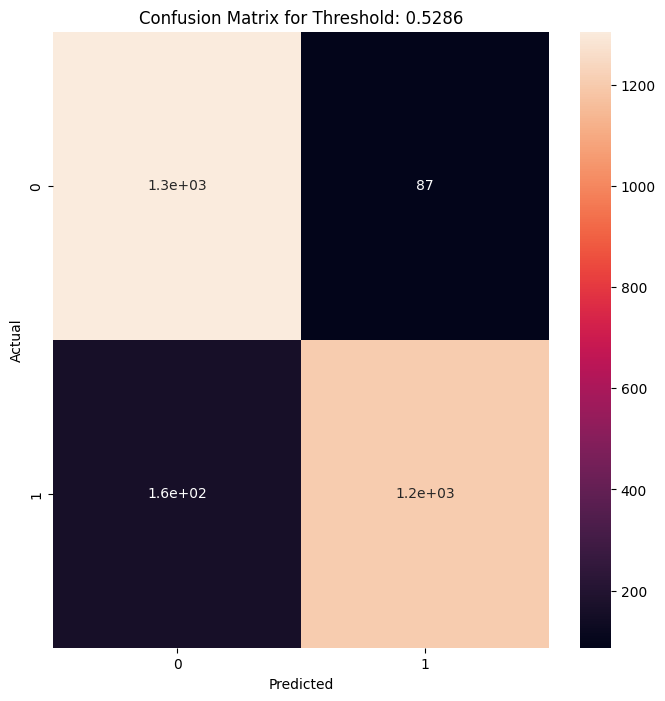

In [52]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True)
plt.title(f'Confusion Matrix for Threshold: {threshold}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

**ROC PLOTS**

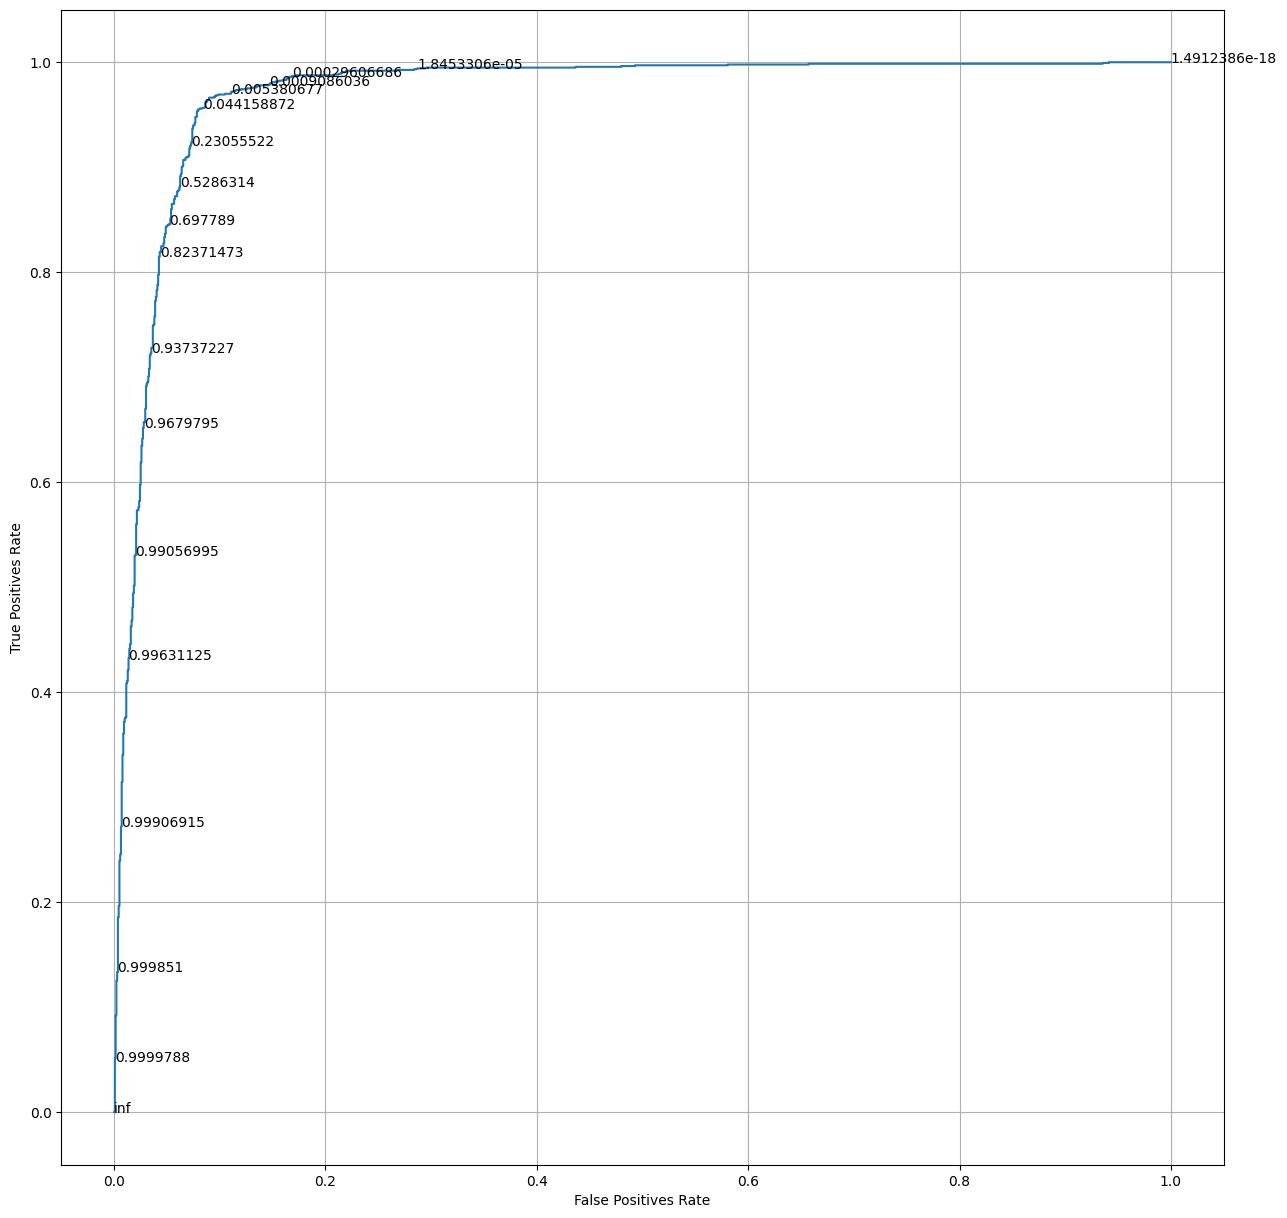

In [50]:
fp, tp, threshold = roc_curve(labels, predicted)
plt.figure(figsize=(15, 15))
plt.plot(fp, tp)

plt.xlabel('False Positives Rate')
plt.ylabel('True Positives Rate')

skip=20
plt.grid()
for i in range(0, len(threshold), skip):
    plt.text(fp[i], tp[i], threshold[i])
plt.show()

**Callbacks**